In [2]:
%load_ext autoreload
%autoreload 2

### 2. Test the Foward part of the Network
> * Now make sure that we can map from an image into an SxSx2x11 Tensor
> * First make sure that the Yolo2 weights are loadable and make sense.

In [3]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
from Model.vis_utils import visualize_grid

/Users/likhuva/anaconda2/envs/cs231n/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### 2.1 Overfit Localizer in Tiny Data
> * For debugging, we run the foward, and backward pass for `a few`
epochs.

In [4]:
import torch
print(torch.__version__)
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from Model.dataloader import NutritionDataset
from Model.net import LocalizerNet
from train import train_localizer, calculate_iou

0.4.0


In [5]:
def train_localizer_network():
    IMAGE_DIR = '../Data/FullData/RawImages/'
    BOXES = '../Data/FullData/BoundingBoxes.npy'
    DATA_PATH = '../Data/FullData/train_dev_test.npy'
    YOLO_PATH = '../Data/FullData/yolo.h5'
    MEAN_PATH='../Data/FullData/270_480_mean.npy'
    debug = not torch.cuda.is_available()
    dataset = DataLoader(
        NutritionDataset(
            IMAGE_DIR, BOXES, DATA_PATH, debug=debug,  
            mean_normalize=False, mean_path=MEAN_PATH
        ),
        batch_size=116, shuffle=True, num_workers=8,
    )
    dev = DataLoader(
        NutritionDataset(
            IMAGE_DIR, BOXES, DATA_PATH, split='dev', debug=debug,
            mean_normalize=False, mean_path=MEAN_PATH
        ),
        batch_size=116, shuffle=True, num_workers=8,
    )
    config = {
        'keep_prob' : 0.99995
    }
    model = LocalizerNet(YOLO_PATH, use_full_yolo=True, config_params=config)
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1.5e-6, weight_decay=0.00005
    )
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, [25, 50, 75],
        gamma=0.995
    )
    r = train_localizer(
        model, optimizer, dataset, dev, epochs=5, 
        scheduler=scheduler, restore=True, save=False
    )
    return r   

In [116]:
train_losses, dev_losses, train_map, dev_map = train_localizer_network()

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.0013575347838923335
	 Dev Loss =  0.0044625066220760345
	 Train mAP =  [0.9 0.9 0.9 0.7 0.2]
	 Dev mAP =  [0.7 0.6 0.2 0.1 0. ]


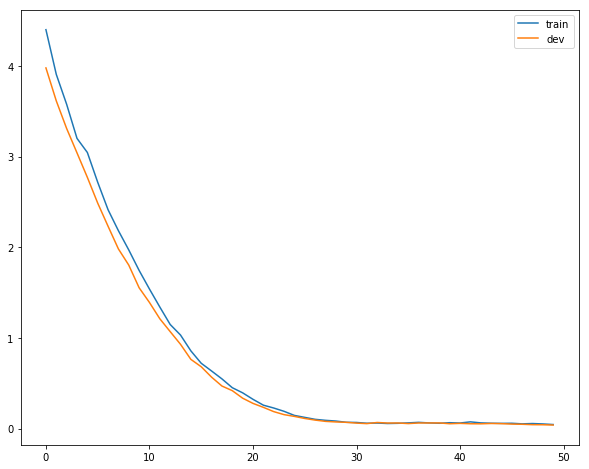

In [102]:
plt.plot(train_losses[:], label='train')
plt.plot(dev_losses[:], label='dev')
plt.legend()

In [104]:
# plt.plot(dev_map[:], label='dev')
# plt.plot(train_map[:], label='train')
# plt.savefig('goals2.png')
# np.save('train_map', train_map)
# np.save('dev_map', dev_map)
# plt.legend()

In [41]:
def calculate_mean_image(
    IMAGE_DIR='../Data/FullData/RawImages/',
    yolo=True
):
    from tqdm import tqdm_notebook as tqdm
    '''
    calculate the mean image on the training set at 
    different sizes, (270, 480) and (540, 960)
    '''
    DATA_PATH = '../Data/FullData/train_dev_test.npy'
    if not yolo:
        image_paths = [os.path.join(IMAGE_DIR, '0_'+f) for f in np.load(DATA_PATH).item()['train']]
        image_paths += [os.path.join(IMAGE_DIR, '1_'+f) for f in np.load(DATA_PATH).item()['train']]
    N = len(image_paths)
    if yolo:
        mean_270, mean_540 = np.zeros((480, 270, 3)), np.zeros((960, 540, 3))
        for img in tqdm(image_paths):
            mean_270 += resized_image((1080//4, 1920//4), img)
            mean_540 += resized_image((1080//2, 1920//2), img)
        return mean_270 / N, mean_540 / N
    else:
        mean_512 = np.zeros((512, 512, 3))
        for img in tqdm(image_paths):
            with Image.open(img) as i:
                mean_512 += np.asarray(i, dtype=np.float32)/N
        return mean_512

def resized_image(size, path):
    with Image.open(path) as img:
        img = img.resize(size, resample=Image.BILINEAR)
        img = np.asarray(img)
    return img

### We now visualize the data trail

In [6]:
d_map = np.array(np.load('./dev_map.npy')); t_map = np.array(np.load('./train_map.npy'))

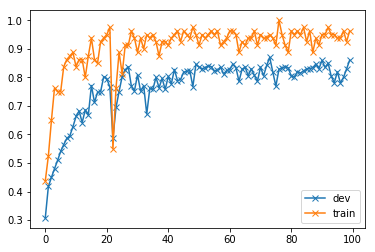

In [8]:
plt.plot(d_map[:, 0], '-x', label='dev')
plt.plot(t_map[:, 0], '-x', label='train')
plt.legend()